In [4]:
import numpy as np
import torch
from torch import nn
import torchvision.models as models
import torchvision
from revuresnet18 import revuresnet18
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
from parallel import DataParallelModel, DataParallelCriterion

In [3]:
class Model2p5d(torch.nn.Module):
    def __init__(self):
        super(Model2p5d, self).__init__()
        self.model = models.resnet18(pretrained = True)
         
        module_list = list()
        
        in_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        module_list.append(nn.Sequential(
                                
        module_list.append(self.model.layer1)
        module_list.append(self.model.layer2)
        module_list.append(self.model.layer3)
        module_list.append(self.model.layer4)
        self.encoder = nn.ModuleList(module_list)
        
        out_planes = [3,1,1]
        layer_names = ['normal','depth','sil']
        
        self.decoders = {}
        for out_plane, layer_name in zip(out_planes, layer_names):
            module_list2 = list()
            revresnet = revuresnet18(out_planes=out_plane)
            module_list2.append(revresnet.layer1)
            module_list2.append(revresnet.layer2)
            module_list2.append(revresnet.layer3)
            module_list2.append(revresnet.layer4)
            module_list2.append(
                nn.Sequential(
                    revresnet.deconv1,
                    revresnet.bn1,
                    revresnet.relu,
                    revresnet.deconv2
                )
            )
            module_list2 = nn.ModuleList(module_list2)
            setattr(self, 'decoder_' + layer_name, module_list2)
            self.decoders[layer_name] = module_list2
        
    def forward(self,im):
        feat = im
        feat_maps = list()
        for f in self.encoder:
            feat = f(feat)
            feat_maps.append(feat)
            
        self.encoder_out = feat_maps[-1]
        
        outputs = {}
        for layer_name, decoder in self.decoders.items():
            x = feat_maps[-1]
            for idx, f in enumerate(decoder):
                x = f(x)
                if idx < len(decoder) - 1:
                    feat_map = feat_maps[-(idx + 2)]
                    assert feat_map.shape[2:4] == x.shape[2:4]
                    x = torch.cat((x, feat_map), dim=1)
            outputs[layer_name] = x
        return outputs

In [ ]:
class Trainer():
    def __init__(self,model):
        self.model = model
        
    def Dataloader(index, batch_size):
        superpath = "/home/ghostvortex/Documents/DL_Project/Dataset/"
        input_img = []
        normal_img = []
        depth_img = []
        sil_img = []
        for folder in sorted(os.listdir(superpath))[index+1:(index+int(batch_size/20)+1)]:
            for folder_in in sorted(os.listdir(superpath+folder)):
                for files in sorted(os.listdir(superpath+folder+"/"+folder_in)):
                    if "rgb" in files:
                        img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                        transform = torchvision.transforms.ToTensor()
                        img = transform(img).unsqueeze(0)
                        input_img.append(img)
                    elif "depth" in files:
                        img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                        transform = torchvision.transforms.ToTensor()
                        img = transform(img[:,:,0]).unsqueeze(0)
                        depth_img.append(img)
                    elif "normal" in files:
                        img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                        transform = torchvision.transforms.ToTensor()
                        img = transform(img).unsqueeze(0)
                        normal_img.append(img)
                    elif "sil" in files:
                        img = cv2.imread(superpath+folder+"/"+folder_in+"/"+files)
                        transform = torchvision.transforms.ToTensor()
                        img = transform(img[:,:,0]).unsqueeze(0)
                        sil_img.append(img)
        input_img1 = torch.cat(input_img, dim=0)
        normal_img1 = torch.cat(normal_img, dim=0)
        depth_img1 = torch.cat(depth_img, dim=0)
        sil_img1 = torch.cat(sil_img, dim=0)
        labels = {}
        labels['normal'] = normal_img1
        labels['depth'] = depth_img1
        labels['sil'] = sil_img1
        return input_img1, labels
        
    def train(self, model):
        num_epochs = 100
        batch_size = 500                                        # Multiples of 20 (Very Important) 
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        
#         parallel_model = DataParallelModel(model)             # Encapsulate the model
#         parallel_loss  = DataParallelCriterion(criterion)     # Encapsulate the loss function
        
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = nn.DataParallel(model)
        model.to(device)

        for epoch in range(num_epochs):
            ind = 0
            for i in range(87):        # Total number of objects (2150) / (Batch size / no.of views) [500/20]
                img, labels_bat = Dataloader(ind, batch_size)
                inp = img.to(device)
                output = model.forward(inp)
                
                loss_normal = parallel_loss(output['normal'], labels_bat['normal'])
                loss_depth = parallel_loss(output['depth'], labels_bat['depth'])
                loss_sil = parallel_loss(output['sil'], labels_bat['sil'])
                loss = loss_normal + loss_depth + loss_sil            
            
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                ind += batch_size
                
            if epoch % 10 == 9: print("Epoch: ", epoch , "Loss: ", loss.item())
        return model
                
model = Model2p5d()
trainer = Trainer(model)
trained_model = trainer.train(model)

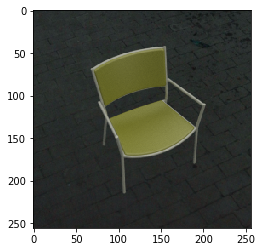

In [57]:
img = cv2.imread("temp_results/rgb.png")
img = cv2.resize(img, (256,256))
import matplotlib.pyplot as plt
plt.imshow(img)
transform = torchvision.transforms.ToTensor()
img = transform(img).unsqueeze(0)
output = trained_model.forward(img)

(256, 256)


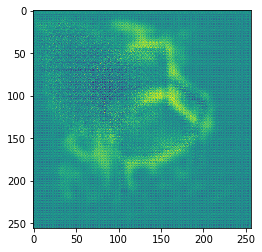

In [58]:
sil = output['sil'].detach().numpy().squeeze()
print(sil.shape)
plt.imshow(sil)
plt.show()

(256, 256)


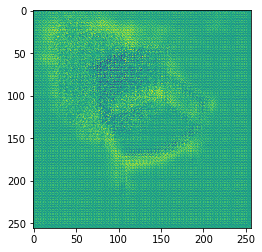

In [59]:
depth = output['depth'].detach().numpy().squeeze()
print(depth.shape)
plt.imshow(depth)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256)


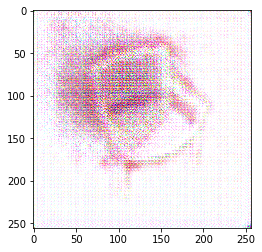

In [60]:
normal = output['normal'].detach().numpy().squeeze()
print(normal.shape)
normal = normal.transpose(1,2,0)
plt.imshow(normal)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


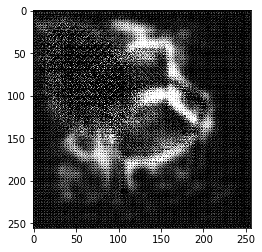

In [61]:
sil = np.resize(sil,(1,256,256))
sil = np.vstack((sil,sil,sil))
sil = sil.transpose(1,2,0)
print(sil.shape)
plt.imshow(sil)
plt.show()

In [41]:
from PIL import Image
import cv2
import numpy as np
img = cv2.imread("chair.png")
img = cv2.resize(img, (256,256))
transform = torchvision.transforms.ToTensor()
img = transform(img).unsqueeze(0)
train = Model2p5d()
output = train.forward(img)
print("Normal:", output['normal'].shape)
print("Depth:", output['depth'].shape)
print("Silhouette:", output['sil'].shape)

Normal: torch.Size([1, 3, 256, 256])
Depth: torch.Size([1, 1, 256, 256])
Silhouette: torch.Size([1, 1, 256, 256])
